# 📊 Projeto – Naive Bayes

Uma **clínica de endocrinologia** recebeu dados de um estudo sobre **obesidade**, onde os respondentes preencheram um formulário com:

- Hábitos de saúde (alimentação e exercícios)  
- Condições físicas  
- Informações complementares como idade, gênero e histórico familiar  

Com base nessas informações, o respondente também indicava se é ou não obeso.

---

## 🎯 Objetivo

A clínica deseja **validar** se esse conjunto de dados pode ser utilizado para **prever** se um novo paciente é obeso ou não, com base nas respostas fornecidas em um **formulário similar**.

---

## 🧠 Abordagem

Será construído um **classificador binário** usando o **algoritmo de Naive Bayes** para:

- Definir (prever) se um paciente é ou não obeso  
- Utilizando exclusivamente os dados fornecidos no formulário

---

## ⚠️ Observação Importante

O questionário **não possui informações como peso e altura**, que poderiam indicar obesidade de forma direta (via cálculo do IMC).  
Portanto, o modelo precisa inferir isso **apenas com base nos hábitos e histórico informado**.


In [87]:
# EDA
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import sweetviz as sv

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score

# Otimizacao de hiperparametros
import optuna

In [88]:
# carregar dataset
df_obesidade = pd.read_csv('./datasets/dataset_obesidade.csv')

In [89]:
# mostrar os primeiros registros do dataframe
df_obesidade.head(5)

,Genero_Masculino,Idade,Historico_Familiar_Sobrepeso,Consumo_Alta_Caloria_Com_Frequencia,Consumo_Vegetais_Com_Frequencia,Refeicoes_Dia,Consumo_Alimentos_entre_Refeicoes,Fumante,Consumo_Agua,Monitora_Calorias_Ingeridas,Nivel_Atividade_Fisica,Nivel_Uso_Tela,Consumo_Alcool,Transporte_Automovel,Transporte_Bicicleta,Transporte_Motocicleta,Transporte_Publico,Transporte_Caminhada,Obeso
0,0,21.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,0,0,0,1,0,0
1,0,21.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,0,0,0,1,0,0
2,1,23.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,0,0,0,1,0,0
3,1,27.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,0,0,0,0,1,0
4,1,22.0,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,0,0,0,1,0,0


In [90]:
# mostrar os ultimos registros do dataframe
df_obesidade.tail(5)

,Genero_Masculino,Idade,Historico_Familiar_Sobrepeso,Consumo_Alta_Caloria_Com_Frequencia,Consumo_Vegetais_Com_Frequencia,Refeicoes_Dia,Consumo_Alimentos_entre_Refeicoes,Fumante,Consumo_Agua,Monitora_Calorias_Ingeridas,Nivel_Atividade_Fisica,Nivel_Uso_Tela,Consumo_Alcool,Transporte_Automovel,Transporte_Bicicleta,Transporte_Motocicleta,Transporte_Publico,Transporte_Caminhada,Obeso
2106,0,20.976842,1,1,3.0,3.0,1,0,1.728139,0,1.676269,0.906247,1,0,0,0,1,0,1
2107,0,21.982942,1,1,3.0,3.0,1,0,2.005130,0,1.341390,0.599270,1,0,0,0,1,0,1
2108,0,22.524036,1,1,3.0,3.0,1,0,2.054193,0,1.414209,0.646288,1,0,0,0,1,0,1
2109,0,24.361936,1,1,3.0,3.0,1,0,2.852339,0,1.139107,0.586035,1,0,0,0,1,0,1
2110,0,23.664709,1,1,3.0,3.0,1,0,2.863513,0,1.026452,0.714137,1,0,0,0,1,0,1


In [91]:
# mostrar estrutura / schema do dataframe
df_obesidade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Genero_Masculino                     2111 non-null   int64  
 1   Idade                                2111 non-null   float64
 2   Historico_Familiar_Sobrepeso         2111 non-null   int64  
 3   Consumo_Alta_Caloria_Com_Frequencia  2111 non-null   int64  
 4   Consumo_Vegetais_Com_Frequencia      2111 non-null   float64
 5   Refeicoes_Dia                        2111 non-null   float64
 6   Consumo_Alimentos_entre_Refeicoes    2111 non-null   int64  
 7   Fumante                              2111 non-null   int64  
 8   Consumo_Agua                         2111 non-null   float64
 9   Monitora_Calorias_Ingeridas          2111 non-null   int64  
 10  Nivel_Atividade_Fisica               2111 non-null   float64
 11  Nivel_Uso_Tela                

In [92]:
# converter colunas para tipo inteiro
lista_colunas = ['Idade', 'Consumo_Vegetais_Com_Frequencia', 'Refeicoes_Dia', 'Consumo_Agua', 'Nivel_Atividade_Fisica', 'Nivel_Uso_Tela']

df_obesidade[lista_colunas] = df_obesidade[lista_colunas].astype(int)

In [93]:
# detectar valores ausentes
df_obesidade.isna().sum()

Genero_Masculino                       0
Idade                                  0
Historico_Familiar_Sobrepeso           0
Consumo_Alta_Caloria_Com_Frequencia    0
Consumo_Vegetais_Com_Frequencia        0
Refeicoes_Dia                          0
Consumo_Alimentos_entre_Refeicoes      0
Fumante                                0
Consumo_Agua                           0
Monitora_Calorias_Ingeridas            0
Nivel_Atividade_Fisica                 0
Nivel_Uso_Tela                         0
Consumo_Alcool                         0
Transporte_Automovel                   0
Transporte_Bicicleta                   0
Transporte_Motocicleta                 0
Transporte_Publico                     0
Transporte_Caminhada                   0
Obeso                                  0
dtype: int64

### EDA

In [94]:
# distribuicao da variavel target - obesidade
px.bar(df_obesidade.value_counts('Obeso'))

In [95]:
# distribuicao da variavel target - obesidade
px.bar(df_obesidade.value_counts('Obeso') / len(df_obesidade) * 100)

In [96]:
# analise univariada
px.histogram(df_obesidade, x='Idade')

In [97]:
 # analise univariada - idade
px.box(df_obesidade, y='Idade')

In [98]:
# analise univariada - genero
px.bar(df_obesidade.value_counts('Genero_Masculino') / len(df_obesidade) * 100)

In [99]:
# analise univariada - historico obesidade na familia
px.bar(df_obesidade.value_counts('Historico_Familiar_Sobrepeso') / len(df_obesidade) * 100)

In [100]:
# analise univariada - nivel de exercicio
px.bar(df_obesidade.value_counts('Nivel_Atividade_Fisica') / len(df_obesidade) * 100)

In [101]:
# analise univariada - nivel de uso de tela
px.bar(df_obesidade.value_counts('Nivel_Uso_Tela') / len(df_obesidade) * 100)

In [102]:
# formulacao de hipotese
# faixa etaria influencia em obesidade
df_obesidade['Idade'].describe()

count    2111.000000
mean       23.972525
std         6.308664
min        14.000000
25%        19.000000
50%        22.000000
75%        26.000000
max        61.000000
Name: Idade, dtype: float64

In [103]:
# bucketing de idade
bins = [10, 20, 30, 40, 50, 60, 70]
bins_ordinal = [0, 1, 2, 3, 4, 5]
labels_faixa_etaria = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70']
df_obesidade['Faixa_Etaria_String'] = pd.cut(x = df_obesidade['Idade'], bins=bins, labels=labels_faixa_etaria, include_lowest=True)
df_obesidade['Faixa_Etaria'] = pd.cut(x = df_obesidade['Idade'], bins=bins, labels=bins_ordinal, include_lowest=True)


In [104]:
df_obesidade

,Genero_Masculino,Idade,Historico_Familiar_Sobrepeso,Consumo_Alta_Caloria_Com_Frequencia,Consumo_Vegetais_Com_Frequencia,Refeicoes_Dia,Consumo_Alimentos_entre_Refeicoes,Fumante,Consumo_Agua,Monitora_Calorias_Ingeridas,...,Nivel_Uso_Tela,Consumo_Alcool,Transporte_Automovel,Transporte_Bicicleta,Transporte_Motocicleta,Transporte_Publico,Transporte_Caminhada,Obeso,Faixa_Etaria_String,Faixa_Etaria
0,0,21,1,0,2,3,1,0,2,0,...,1,0,0,0,0,1,0,0,20-30,1
1,0,21,1,0,3,3,1,1,3,1,...,0,1,0,0,0,1,0,0,20-30,1
2,1,23,1,0,2,3,1,0,2,0,...,1,2,0,0,0,1,0,0,20-30,1
3,1,27,0,0,3,3,1,0,2,0,...,0,2,0,0,0,0,1,0,20-30,1
4,1,22,0,0,2,1,1,0,2,0,...,0,1,0,0,0,1,0,0,20-30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20,1,1,3,3,1,0,1,0,...,0,1,0,0,0,1,0,1,10-20,0
2107,0,21,1,1,3,3,1,0,2,0,...,0,1,0,0,0,1,0,1,20-30,1
2108,0,22,1,1,3,3,1,0,2,0,...,0,1,0,0,0,1,0,1,20-30,1
2109,0,24,1,1,3,3,1,0,2,0,...,0,1,0,0,0,1,0,1,20-30,1


In [105]:
# criar uma tabela de contingencia - faixa etaria e obesidade
tabela_contingencia_faixa_etaria = sm.stats.Table.from_data(df_obesidade[['Obeso', 'Faixa_Etaria_String']])

In [106]:
tabela_contingencia_faixa_etaria.table_orig

Faixa_Etaria_String,10-20,20-30,30-40,40-50,50-60,60-70
Obeso,,,,,,
0,498,489,131,13,7,1
1,176,649,127,19,1,0


In [107]:
# teste de chi-square de pearson
print(tabela_contingencia_faixa_etaria.test_nominal_association())

df          5
pvalue      0.0
statistic   170.1116865347508


In [108]:
# p-value < 0.05, rejeitamos H0, portando as variaveis nao sao independentes

### Treinamento do Modelo - Baseline

In [109]:
# dividir dados de treino e teste
X = df_obesidade.drop(columns=['Obeso', 'Idade', 'Faixa_Etaria_String'], axis=1)
y = df_obesidade['Obeso']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51, shuffle=True)

In [110]:
# treinamento do modelo
model_baseline = GaussianNB()
model_baseline.fit(X_train, y_train)

GaussianNB()

### Métricas do Modelo Baseline

In [111]:
# predizer valores do conjunto de teste
y_pred = model_baseline.predict(X_test)

In [112]:
classification_report_str = classification_report(y_test, y_pred)
recall_baseline = recall_score(y_test, y_pred, average='macro')
print(f'Relatório de Classificação: \n{classification_report_str}')
print(f'Recall: {recall_baseline}')

Relatório de Classificação: 
              precision    recall  f1-score   support

           0       0.94      0.60      0.73       339
           1       0.67      0.96      0.79       295

    accuracy                           0.76       634
   macro avg       0.81      0.78      0.76       634
weighted avg       0.82      0.76      0.76       634

Recall: 0.775901204939753


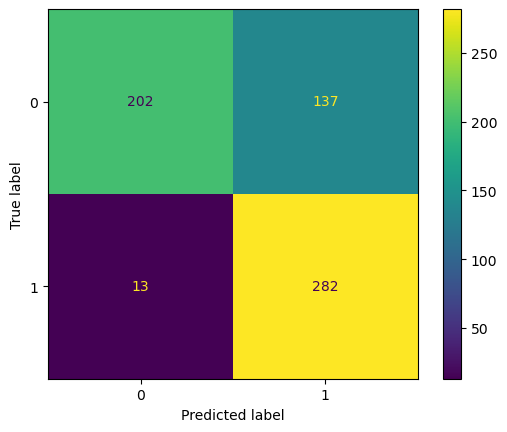

In [113]:
# mostrar matriz de confusao
confusion_matrix_modelo_baseline = confusion_matrix(y_test, y_pred)
disp_modelo_baseline = ConfusionMatrixDisplay(confusion_matrix_modelo_baseline)
disp_modelo_baseline.plot()

### Treinamento Modelo - Automated Feature Selection

In [138]:
# select KBest - seleciona as k melhores features, baseado em um teste
kbest = SelectKBest(score_func=chi2, k=8)

In [139]:
X_train_kbest = kbest.fit_transform(X_train, y_train)

In [140]:
X_train_kbest

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 2],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 2],
       [1, 1, 3, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 1]], shape=(1477, 8))

In [141]:
# features selecionadas
kbest_features = kbest.get_support(indices=True)
X_train_best_features = X_train.iloc[:, kbest_features]
X_train_best_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 301 to 2105
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Historico_Familiar_Sobrepeso         1477 non-null   int64   
 1   Consumo_Alta_Caloria_Com_Frequencia  1477 non-null   int64   
 2   Consumo_Alimentos_entre_Refeicoes    1477 non-null   int64   
 3   Monitora_Calorias_Ingeridas          1477 non-null   int64   
 4   Nivel_Atividade_Fisica               1477 non-null   int64   
 5   Nivel_Uso_Tela                       1477 non-null   int64   
 6   Transporte_Caminhada                 1477 non-null   int64   
 7   Faixa_Etaria                         1477 non-null   category
dtypes: category(1), int64(7)
memory usage: 94.0 KB


In [142]:
kbest_features

array([ 1,  2,  5,  8,  9, 10, 16, 17])

In [143]:
# treinar modelo com as melhores features
modelo_kbest = GaussianNB()
modelo_kbest.fit(X_train_best_features, y_train)

GaussianNB()

### Métricas do Modelo Select KBest

In [144]:
# filtrar as features nos dados de teste
X_test_kbest = kbest.transform(X_test)
X_train_best_features = X_test.iloc[:, kbest_features]

In [145]:
# predizer valores do conjunto de teste
y_pred_kbest = modelo_kbest.predict(X_train_best_features)

In [146]:
classification_report_str = classification_report(y_test, y_pred_kbest)
recall_baseline = recall_score(y_test, y_pred_kbest, average='macro')
print(f'Relatório de Classificação (KBest): \n{classification_report_str}')
print(f'Recall (KBest): {recall_baseline}')

Relatório de Classificação (KBest): 
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       339
           1       0.68      0.95      0.79       295

    accuracy                           0.77       634
   macro avg       0.81      0.78      0.76       634
weighted avg       0.82      0.77      0.76       634

Recall (KBest): 0.780105994700265


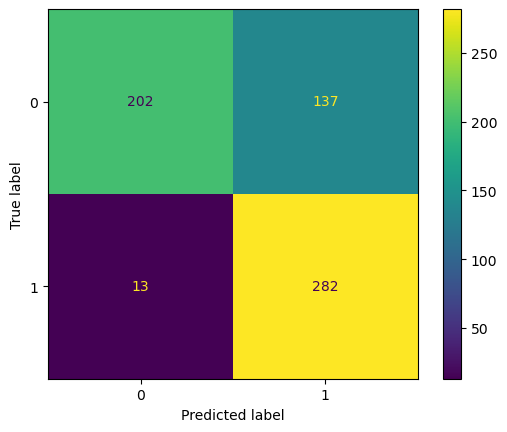

In [147]:
# mostrar matriz de confusao
confusion_matrix_modelo_kbest = confusion_matrix(y_test, y_pred_kbest)
disp_modelo_kbest = ConfusionMatrixDisplay(confusion_matrix_modelo_baseline)
disp_modelo_kbest.plot()

### Tuning de Hiperparâmetros

In [131]:
# ajustar hiperparametros do selectkbest
# k = k melhores features conforme chi2

def naivebayes_optuna(trial):

    k = trial.suggest_int('k', 1, 18)

    kbest = SelectKBest(score_func=chi2, k=k)

    X_train_kbest = kbest.fit_transform(X_train, y_train)

    kbest_features = kbest.get_support(indices=True)
    X_train_best_features = X_train.iloc[:, kbest_features]

    # treinar o modelo com melhores features
    model_kbest_optuna = GaussianNB()
    model_kbest_optuna.fit(X_train_best_features, y_train)

    # aplicar seletor de features no conjunto de testes
    X_test_kbest = kbest.transform(X_test)
    X_test_best_features = X_test.iloc[:, kbest_features]

    # predizer valores
    y_pred_kbest = model_kbest_optuna.predict(X_test_best_features)

    # avaliar recall
    recall_optuna = recall_score(y_test, y_pred_kbest, average='macro')

    return k, recall_optuna

In [132]:
# rodar o estudo dos hiperparametros
search_space = {'k': range(1, 19)}
estudo_naivebayes = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space= search_space), directions=['minimize', 'maximize'])
estudo_naivebayes.optimize(naivebayes_optuna, n_trials=50)

[I 2025-04-14 20:50:21,674] A new study created in memory with name: no-name-2a3d1990-429d-45cf-b0e9-32aab533c6d8
[I 2025-04-14 20:50:21,685] Trial 0 finished with values: [2.0, 0.6659517024148793] and parameters: {'k': 2}.
[I 2025-04-14 20:50:21,695] Trial 1 finished with values: [7.0, 0.748537573121344] and parameters: {'k': 7}.
[I 2025-04-14 20:50:21,703] Trial 2 finished with values: [9.0, 0.775681215939203] and parameters: {'k': 9}.
[I 2025-04-14 20:50:21,713] Trial 3 finished with values: [11.0, 0.7727313634318285] and parameters: {'k': 11}.
[I 2025-04-14 20:50:21,722] Trial 4 finished with values: [15.0, 0.7742062896855157] and parameters: {'k': 15}.
[I 2025-04-14 20:50:21,731] Trial 5 finished with values: [5.0, 0.6950002499875007] and parameters: {'k': 5}.
[I 2025-04-14 20:50:21,739] Trial 6 finished with values: [3.0, 0.6138143092845358] and parameters: {'k': 3}.
[I 2025-04-14 20:50:21,749] Trial 7 finished with values: [17.0, 0.775901204939753] and parameters: {'k': 17}.
[I 

In [136]:
# mostrar melhore resultado
trial_com_melhor_recall = max(estudo_naivebayes.best_trials, key=lambda t: t.values[1])
print('Trial com maior recall e menor k:')
print(f'\tTrial number: {trial_com_melhor_recall.number}')
print(f'\tparam (k): {trial_com_melhor_recall.params}')
print(f'\tvalues (k, recall): {trial_com_melhor_recall.values}')

Trial com maior recall e menor k:
	Trial number: 10
	param (k): {'k': 8}
	values (k, recall): [8.0, 0.780105994700265]


In [137]:
# mostrar chart com trials
fig = optuna.visualization.plot_pareto_front(estudo_naivebayes)
fig.show()

### Salvar Modelo

In [149]:
import joblib

# salvar modelo
joblib.dump(modelo_kbest, 'modelo_obesidade.pkl')

['modelo_obesidade.pkl']